*arata.suzuki & gabriel.bignet*

# IREN Compétition à la mano

Dans le domaine de la vision par ordinateur, la classification d'images est une tâche essentielle et complexe. Dans ce projet, nous nous concentrons sur un problème de classification spécifique : la classification des types de navires à partir d'images. L'objectif est de développer un modèle de réseau de neurones convolutifs (CNN) personnalisé qui sera capable de reconnaître et de classer différents types de navires avec précision.

La classification des types de navires présente un défi particulier en raison de la variabilité des formes, des tailles et des structures des navires. Les images utilisées dans ce projet sont de taille relativement petite (16x24 pixels), ce qui ajoute une contrainte supplémentaire en termes de résolution et de qualité des données.

Pour résoudre ce problème, nous construirons un modèle CNN à partir de zéro. Notre modèle comprendra moins de 30 couches, ce qui nous permettra de maintenir une complexité raisonnable tout en visant de bonnes performances de classification.

L'évaluation de notre modèle sera basée sur des mesures de performance telles que l'exactitude (accuracy) et la matrice de confusion pour évaluer la capacité du modèle à distinguer les différents types de navires. 

En résumé, ce projet vise à développer un modèle CNN personnalisé avec moins de 30 couches pour la classification des types de navires à partir d'images. Nous chercherons à optimiser la précision de classification tout en maintenant une architecture relativement simple.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


On commence d'abord à prétraiter et charger les données d'images pour notre modèle de classification de types de navires. Le prétraitement des données est une étape cruciale dans la construction d'un modèle CNN performant.

Nous utilisons le module ImageDataGenerator de Keras, qui nous permet de réaliser diverses transformations sur nos images. La première transformation que nous appliquons est la normalisation des valeurs de pixel. En divisant les valeurs de pixel par 255, nous ramenons les valeurs dans une plage de 0 à 1, ce qui facilite le traitement pour notre modèle.

Une autre transformation que nous utilisons est le retournement horizontal. Cette opération crée des versions miroir horizontales des images, ce qui augmente la diversité de notre ensemble de données d'entraînement. Cette technique est particulièrement utile lorsque les données d'entraînement sont limitées, car elle permet d'augmenter artificiellement la taille de l'ensemble de données en créant de nouvelles variations des images existantes.

De plus, nous divisons nos données en un ensemble d'entraînement et un ensemble de validation. Cela nous permet d'évaluer les performances de notre modèle sur des données qu'il n'a pas encore vues. Dans notre cas, nous utilisons 85% des données pour l'entraînement et 15% pour la validation. Cette division nous aide à évaluer la capacité du modèle à généraliser et à éviter le surapprentissage.

Une fois que nous avons défini nos transformations et nos paramètres, nous spécifions le chemin du dossier contenant nos images. Cela nous permet d'accéder facilement à nos données. Nous définissons également la taille cible de nos images, dans notre cas 32x32 pixels (car c'est la taille qui donnait les meilleurs résultats sur la classification). Cette étape est importante car elle assure que toutes les images sont redimensionnées de manière cohérente pour être compatibles avec notre modèle.

Enfin, nous utilisons le générateur d'images (ImageDataGenerator) pour charger et prétraiter nos données. Nous utilisons la méthode flow_from_directory pour charger les images à partir du dossier spécifié. Cela nous permet de charger les images par lots (batches) afin de ne pas surcharger la mémoire. Nous créons ainsi des générateurs d'images pour l'ensemble d'entraînement et l'ensemble de validation.

In [2]:
from keras.preprocessing.image import ImageDataGenerator

# Créer un générateur d'images
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation des valeurs de pixel entre 0 et 1
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.15  # Fraction des données à utiliser pour la validation
)

# Chargement des images à partir du dossier
image_size = (32, 32)
batch_size = 128

# Définir le chemin du dossier contenant les images
folder_path = "/kaggle/input/navires-2023-la-mano/ships16x24/ships_16x24_10cat/data"

# Utiliser le générateur d'images pour charger et prétraiter les données
train_generator = datagen.flow_from_directory(
    folder_path,
    target_size=image_size,
    batch_size=batch_size,
    seed=SEED,
    subset='training'  # Utiliser une fraction des données pour l'entraînement
)

validation_generator = datagen.flow_from_directory(
    folder_path,
    target_size=image_size,
    batch_size=batch_size,
    seed=SEED,
    subset='validation'  # Utiliser une fraction des données pour la validation
)


Found 30191 images belonging to 10 classes.
Found 5324 images belonging to 10 classes.


On crée ensuite un modèle CNN (Convolutional Neural Network) pour la classification de types de navires à partir d'images.

Dans ce modèle, nous utilisons une architecture en couches séquentielles (Sequential). Chaque couche représente une opération spécifique qui traite les données en entrée.

Nous commençons par les couches de convolution (Conv2D) qui extraient les caractéristiques des images en appliquant des filtres sur des régions locales. La première couche de convolution utilise 64 filtres de taille (3, 3) et une fonction d'activation ReLU pour introduire la non-linéarité. Les couches suivantes utilisent des nombres de filtres plus élevés (128, 256, 512, 1024) pour capturer des informations de plus en plus complexes. Chaque couche de convolution est suivie d'une couche de max pooling (MaxPooling2D) qui réduit la taille spatiale des caractéristiques extraites.

Pour améliorer la stabilité et la performance du modèle, nous utilisons des couches de normalisation par lots (BatchNormalization) après chaque couche de convolution. Cela aide à accélérer la convergence de l'apprentissage en normalisant les activations des couches précédentes.

Pour réduire le risque de surapprentissage, nous ajoutons des couches de dropout (Dropout) après chaque couche de normalisation. Le dropout consiste à désactiver aléatoirement un pourcentage des neurones pendant l'entraînement, ce qui force le modèle à apprendre des caractéristiques plus robustes et à généraliser mieux aux nouvelles données.

Une fois que nous avons appliqué plusieurs couches de convolution, nous aplatissons les caractéristiques en une seule dimension à l'aide de la couche Flatten. Cela nous permet de connecter les caractéristiques extraites aux couches denses (Dense) qui sont des couches entièrement connectées. Nous utilisons des couches denses avec des fonctions d'activation ReLU et des couches de dropout pour introduire de la non-linéarité et éviter le surapprentissage.

Enfin, nous ajoutons une couche de sortie avec une fonction d'activation softmax pour effectuer la classification des types de navires. Cette couche a 10 neurones, correspondant au nombre de classes différentes que nous souhaitons prédire.

Le modèle est compilé en spécifiant l'optimiseur (Adadelta), la fonction de perte (categorical_crossentropy pour la classification multiclasse) et les métriques à évaluer pendant l'entraînement (accuracy pour la précision).

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adadelta


# Création du modèle CNN
model = Sequential()

model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))


# Couche de sortie avec softmax pour la classification
model.add(Dense(10, activation='softmax')) 

# Compilation du modèle
model.compile(optimizer=Adadelta(learning_rate=0.2),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

On va utiliser une fonction callback pour sauvegarder les poids du modèle à chaque amélioration de la performance sur l'ensemble de validation.

Lors de l'entraînement d'un modèle, il est important de surveiller les performances sur les données de validation pour évaluer comment le modèle se comporte sur des données qu'il n'a pas encore vues. Le paramètre monitor est utilisé pour spécifier la métrique à surveiller, ici, val_accuracy, qui est l'exactitude (accuracy) sur l'ensemble de validation.

Le paramètre mode est défini sur 'max' car nous souhaitons maximiser la métrique surveillée.

Le paramètre save_best_only est défini sur True pour ne sauvegarder que les poids du modèle lorsqu'il obtient les meilleures performances sur l'ensemble de validation. Cela permet de conserver uniquement les meilleurs poids et d'éviter de surcharger le disque avec des sauvegardes inutiles.

Le paramètre verbose est réglé sur 1 pour afficher des messages pendant le processus de sauvegarde, ce qui peut être utile pour suivre l'avancement de l'entraînement.

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'model_checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            monitor='val_accuracy',
                                            mode='max',
                                            save_best_only=True,
                                            verbose=1)

On va ensuite entraîner le modèle à l'aide de la méthode fit de Keras. Cette méthode nous permet de mettre en œuvre le processus d'apprentissage du modèle en utilisant les données d'entraînement et de suivre les performances sur l'ensemble de validation.

Nous spécifions plusieurs paramètres importants pour cette étape. Tout d'abord, nous utilisons train_generator comme ensemble de données d'entraînement. Ce générateur a été créé en utilisant la technique de génération d'images et il permet de charger et de prétraiter les images de manière dynamique pendant l'entraînement.

Nous fixons également la taille des lots (batch_size), qui détermine le nombre d'échantillons traités à chaque itération de l'algorithme d'optimisation. Le choix de cette taille peut avoir un impact sur la convergence du modèle et l'utilisation de la mémoire.

Le nombre d'époques (nb_epochs) correspond au nombre de fois où le modèle parcourt l'ensemble complet des données d'entraînement. Chaque époque représente une itération complète à travers toutes les données d'entraînement, permettant ainsi au modèle d'apprendre progressivement à partir des exemples.

Nous utilisons également validation_generator comme ensemble de données de validation pour évaluer les performances du modèle à chaque époque. Cela nous permet de surveiller l'évolution des métriques d'évaluation, telles que l'exactitude et la perte, sur cet ensemble de données afin de détecter d'éventuels problèmes de surapprentissage ou de sous-apprentissage.

Enfin, nous utilisons le callback model_checkpoint_callback que nous avons défini précédemment. Ce callback permet de sauvegarder les poids du modèle lorsque celui-ci obtient les meilleures performances sur l'ensemble de validation. Cela nous assure de conserver les meilleurs paramètres du modèle et de les réutiliser ultérieurement.

In [5]:
nb_epochs = 30
history = model.fit(x=train_generator, batch_size=batch_size, epochs=nb_epochs, validation_data=validation_generator, callbacks=[model_checkpoint_callback])

Epoch 1/30


2023-05-30 07:36:36.711272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


236/236 [==============================] - ETA: 0s - loss: 1.8739 - accuracy: 0.3569
Epoch 1: val_accuracy improved from -inf to 0.14688, saving model to model_checkpoint
236/236 [==============================] - 176s 713ms/step - loss: 1.8739 - accuracy: 0.3569 - val_loss: 2.7394 - val_accuracy: 0.1469
Epoch 2/30
236/236 [==============================] - ETA: 0s - loss: 1.4316 - accuracy: 0.5034
Epoch 2: val_accuracy improved from 0.14688 to 0.34730, saving model to model_checkpoint
236/236 [==============================] - 56s 237ms/step - loss: 1.4316 - accuracy: 0.5034 - val_loss: 2.0045 - val_accuracy: 0.3473
Epoch 3/30
236/236 [==============================] - ETA: 0s - loss: 1.2383 - accuracy: 0.5687
Epoch 3: val_accuracy improved from 0.34730 to 0.59767, saving model to model_checkpoint
236/236 [==============================] - 55s 231ms/step - loss: 1.2383 - accuracy: 0.5687 - val_loss: 1.2084 - val_accuracy: 0.5977
Epoch 4/30
236/236 [==============================] - ET

Dans le cadre de l'évaluation de la performance d'un modèle de réseau de neurones convolutif (CNN), il est important de visualiser l'exactitude d'entraînement et de validation au fil des époques. Pour cela, nous générons un graphique qui représente les courbes d'exactitude d'entraînement et de validation en fonction du nombre d'époques. Ces courbes fournissent une indication visuelle de la progression de l'exactitude du modèle au cours de l'entraînement. Chaque point sur le graphique représente l'exactitude atteinte à une époque spécifique, permettant ainsi de suivre la performance du modèle au fil du temps. Cette visualisation est utile pour détecter d'éventuels problèmes tels que le surapprentissage (overfitting) ou le sous-apprentissage (underfitting) du modèle. L'analyse de ces courbes peut orienter les décisions concernant la durée d'entraînement optimale du modèle ou l'ajustement des paramètres pour améliorer sa performance.

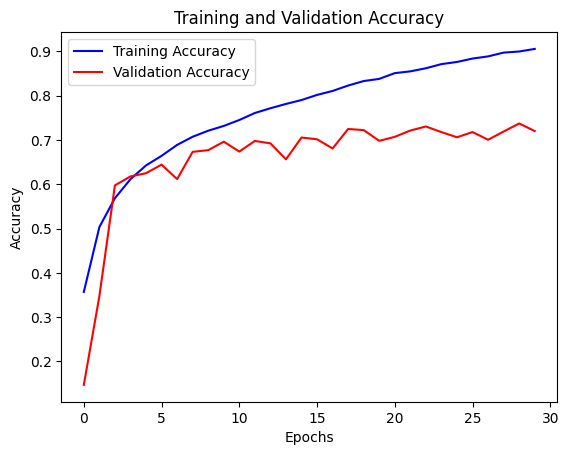

In [6]:
import matplotlib.pyplot as plt

# Récupérer les métriques d'entraînement et de validation
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Récupérer le nombre d'époques
epochs = range(1, nb_epochs+1)

# Tracer les courbes d'exactitude
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


La matrice de confusion est un outil essentiel pour évaluer les performances d'un modèle de classification. Elle permet de visualiser la précision du modèle en comparant les classes prédites avec les classes réelles.

Tout d'abord, les prédictions du modèle sont obtenues pour les données de validation. Ensuite, les vraies classes correspondantes sont récupérées. Les noms des classes sont également extraits.

Ensuite, la matrice de confusion est calculée pour déterminer le nombre de prédictions correctes et incorrectes pour chaque classe.

En utilisant une représentation graphique, la matrice de confusion est affichée. Chaque cellule de la matrice est représentée par une couleur qui indique le nombre de prédictions correspondantes. Les étiquettes des classes sont affichées pour identifier les classes prédites et les classes réelles.

Ce graphique de la matrice de confusion permet d'évaluer rapidement les performances du modèle en identifiant les classes qui sont correctement prédites et celles qui sont confondues. Il fournit des informations précieuses sur les erreurs de classification et peut aider à ajuster le modèle en conséquence pour améliorer ses performances.

42/42 [==============================] - 8s 188ms/step


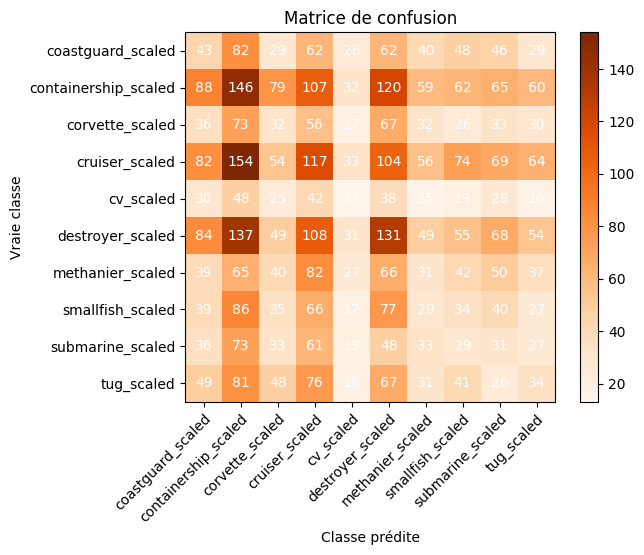

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Prédire les classes pour les données de validation
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtenir les vraies classes des données de validation
y_true = validation_generator.classes

# Obtenir les noms des classes
class_names = list(validation_generator.class_indices.keys())

# Calculer la matrice de confusion
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Afficher la matrice de confusion
fig, ax = plt.subplots()
im = ax.imshow(confusion_mtx, interpolation='nearest', cmap='Oranges')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(confusion_mtx.shape[1]),
       yticks=np.arange(confusion_mtx.shape[0]),
       xticklabels=class_names,
       yticklabels=class_names,
       ylabel='Vraie classe',
       xlabel='Classe prédite')

# Faire en sorte que les étiquettes de l'axe x soient inclinées
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Boucle pour afficher les valeurs dans chaque cellule de la matrice de confusion
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        ax.text(j, i, format(confusion_mtx[i, j], 'd'),
                ha="center", va="center", color="white")

# Titre du graphique
plt.title("Matrice de confusion")

# Afficher le graphique
plt.show()


On charge ensuite les poids du meilleur modèle qu'on a sauvegardé :

In [8]:
model.load_weights(checkpoint_filepath)

In [9]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  28


## Résultat à soumettre

On réalise ensuite à l'aide de notre modèle obtenu les prédictions sur les données de submission, en faisant bien attention à bien redimensionner les images en (32,32) et à le normaliser pour l'adapter à notre modèle.

In [10]:
X_test = np.load('/kaggle/input/navires-2023-la-mano/test.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255

In [11]:
from PIL import Image

# Redimensionner les images de X_test à (32, 32)
resized_X_test = []
for image in X_test:
    pil_image = Image.fromarray((image * 255).astype(np.uint8))
    resized_image = pil_image.resize((32, 32))
    resized_array = np.array(resized_image) / 255.0
    resized_X_test.append(resized_array)

resized_X_test = np.array(resized_X_test)

In [12]:
res = model.predict(resized_X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="Id")

116/116 [==============================] - 2s 10ms/step


In [13]:
!head reco_nav.csv

Id,Category
0,5
1,8
2,5
3,5
4,3
5,0
6,3
7,3
8,5


In [14]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv